In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config Completer.use_jedi = False

In [4]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py, healpy as hp
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

from multiprocessing import Pool

In [5]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

def save_figs(filename):
    plt.savefig(filename+'.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)
    plt.savefig(filename+'.pdf', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)
    # plt.savefig(filename+'_c.pdf', bbox_inches='tight', dpi=50, facecolor='w', transparent=False)

In [6]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/testselectionfunctions/'

# Load as module

In [7]:
from TracerFit import mwfit, int_idx

In [8]:
run_id_mock=28;
size = 1000000
file = "sample4"

model_good = mwfit(sf_bool=False, perr_bool=False)
model_good.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sample4_{size}_sf_perr_{run_id_mock:03d}.h')

model_mt0 = mwfit(sf_bool=False, perr_bool=False)
model_mt0.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sample5_{size}_sf_perr_{run_id_mock:03d}.h')

model_R = mwfit(sf_bool=False, perr_bool=False)
model_R.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_sample7_{size}_sf_perr_{run_id_mock:03d}.h')

dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])
dict_keys(['fixed_pars', 'free_pars', 'mcmc', 'optimize', 'param_trans', 'sf_subset', 'source_id', 'true_pars'])


# Load data

In [9]:
file = "sample4"
with h5py.File(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id_mock:03d}.h', 'r') as hf:
    sf_subset = hf['sf_subset'][...]

In [10]:
# Load Sample
sample = {}; true_pars={};
filename = f'/data/asfe2/Projects/mwtrace_data/mockmodel/{file}.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], model_good.source_id, return_indices=True)[1]
    #subset = np.arange(len(hf['sample']['source_id'][...]))
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[int_idx(key)]=hf['true_pars'][key][...]
        else:
            true_pars[int_idx(key)]={}
            for par in hf['true_pars'][key].keys():
                true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[j]['w']*=len(sample['source_id'])
    
# Apply Gaia Selection Function
# sample['gaiasf_subset'] = sf_utils.apply_gaiasf(sample['l'], np.arcsin(sample['sinb']), sample['m'])[0]

In [11]:
sample['sf_subset'] = sf_subset.copy()

In [12]:
utils_dir = '/data/asfe2/Projects/mwtrace_data/utils/'
model_good._generate_fid_pars(directory=utils_dir)
model_good.sample=sample

model_mt0._generate_fid_pars(directory=utils_dir)
model_mt0.sample=sample

model_R._generate_fid_pars(directory=utils_dir)
model_R.sample=sample

directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars
directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars
directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars


# Plot results

In [13]:
true_params_f = model_good.transform_params(model_good.get_true_params(true_pars))
true_params_f[[2,5,8]] *= -1
true_params_f

array([ 9.39266193, -0.40546511, -5.39916773, 10.66895539, -1.94591015,
       -5.21594169, 13.75894021, -1.57086564, -5.65148617, -2.20727491,
       -1.38629436])

In [14]:
ndim=len(true_params_f); 
plt.rc('axes', labelsize=ndim*3)
plt.rc('xtick',labelsize=ndim*3)
plt.rc('ytick',labelsize=ndim*3)
plt.rc('legend',fontsize=ndim*4)
plt.rc('font',size=ndim*3)

In [15]:
model_good._generate_fid_pars(directory=utils_dir)
functions = [model_good.fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model_good.free_pars[j]]

index = [r'Good', r'$M_\mathrm{TO}^\mathrm{Tn} = 2.9$', r'$R$-free, $q=0.9$']
chains = [model_good.mcmc_results['chain']['sf_perr_mcmc'].copy(),
          model_mt0.mcmc_results['chain']['sf_perr_mcmc'].copy(),
          model_R.mcmc_results['chain']['sf_perr_mcmc'].copy()]
# for i in range(len(chains)): chains[i][:,:,[0,3,6]] = np.log10(chains[i][:,:,[0,3,6]])
# for i in range(len(chains)): chains[i][:,:,[0,3,6]] /= np.log(10)

labels = copy(transformations.label_set)
for i in [0,3,6]: labels[i] = '$\log_{10}(w)$'
for i in [0,3,6]: functions[i]=lambda x:x/np.log(10)
for chain in chains: chain[:,:,[2,5,8]] *= -1

directory:  /data/asfe2/Projects/mwtrace_data/utils/
Got Selectionfunction pars


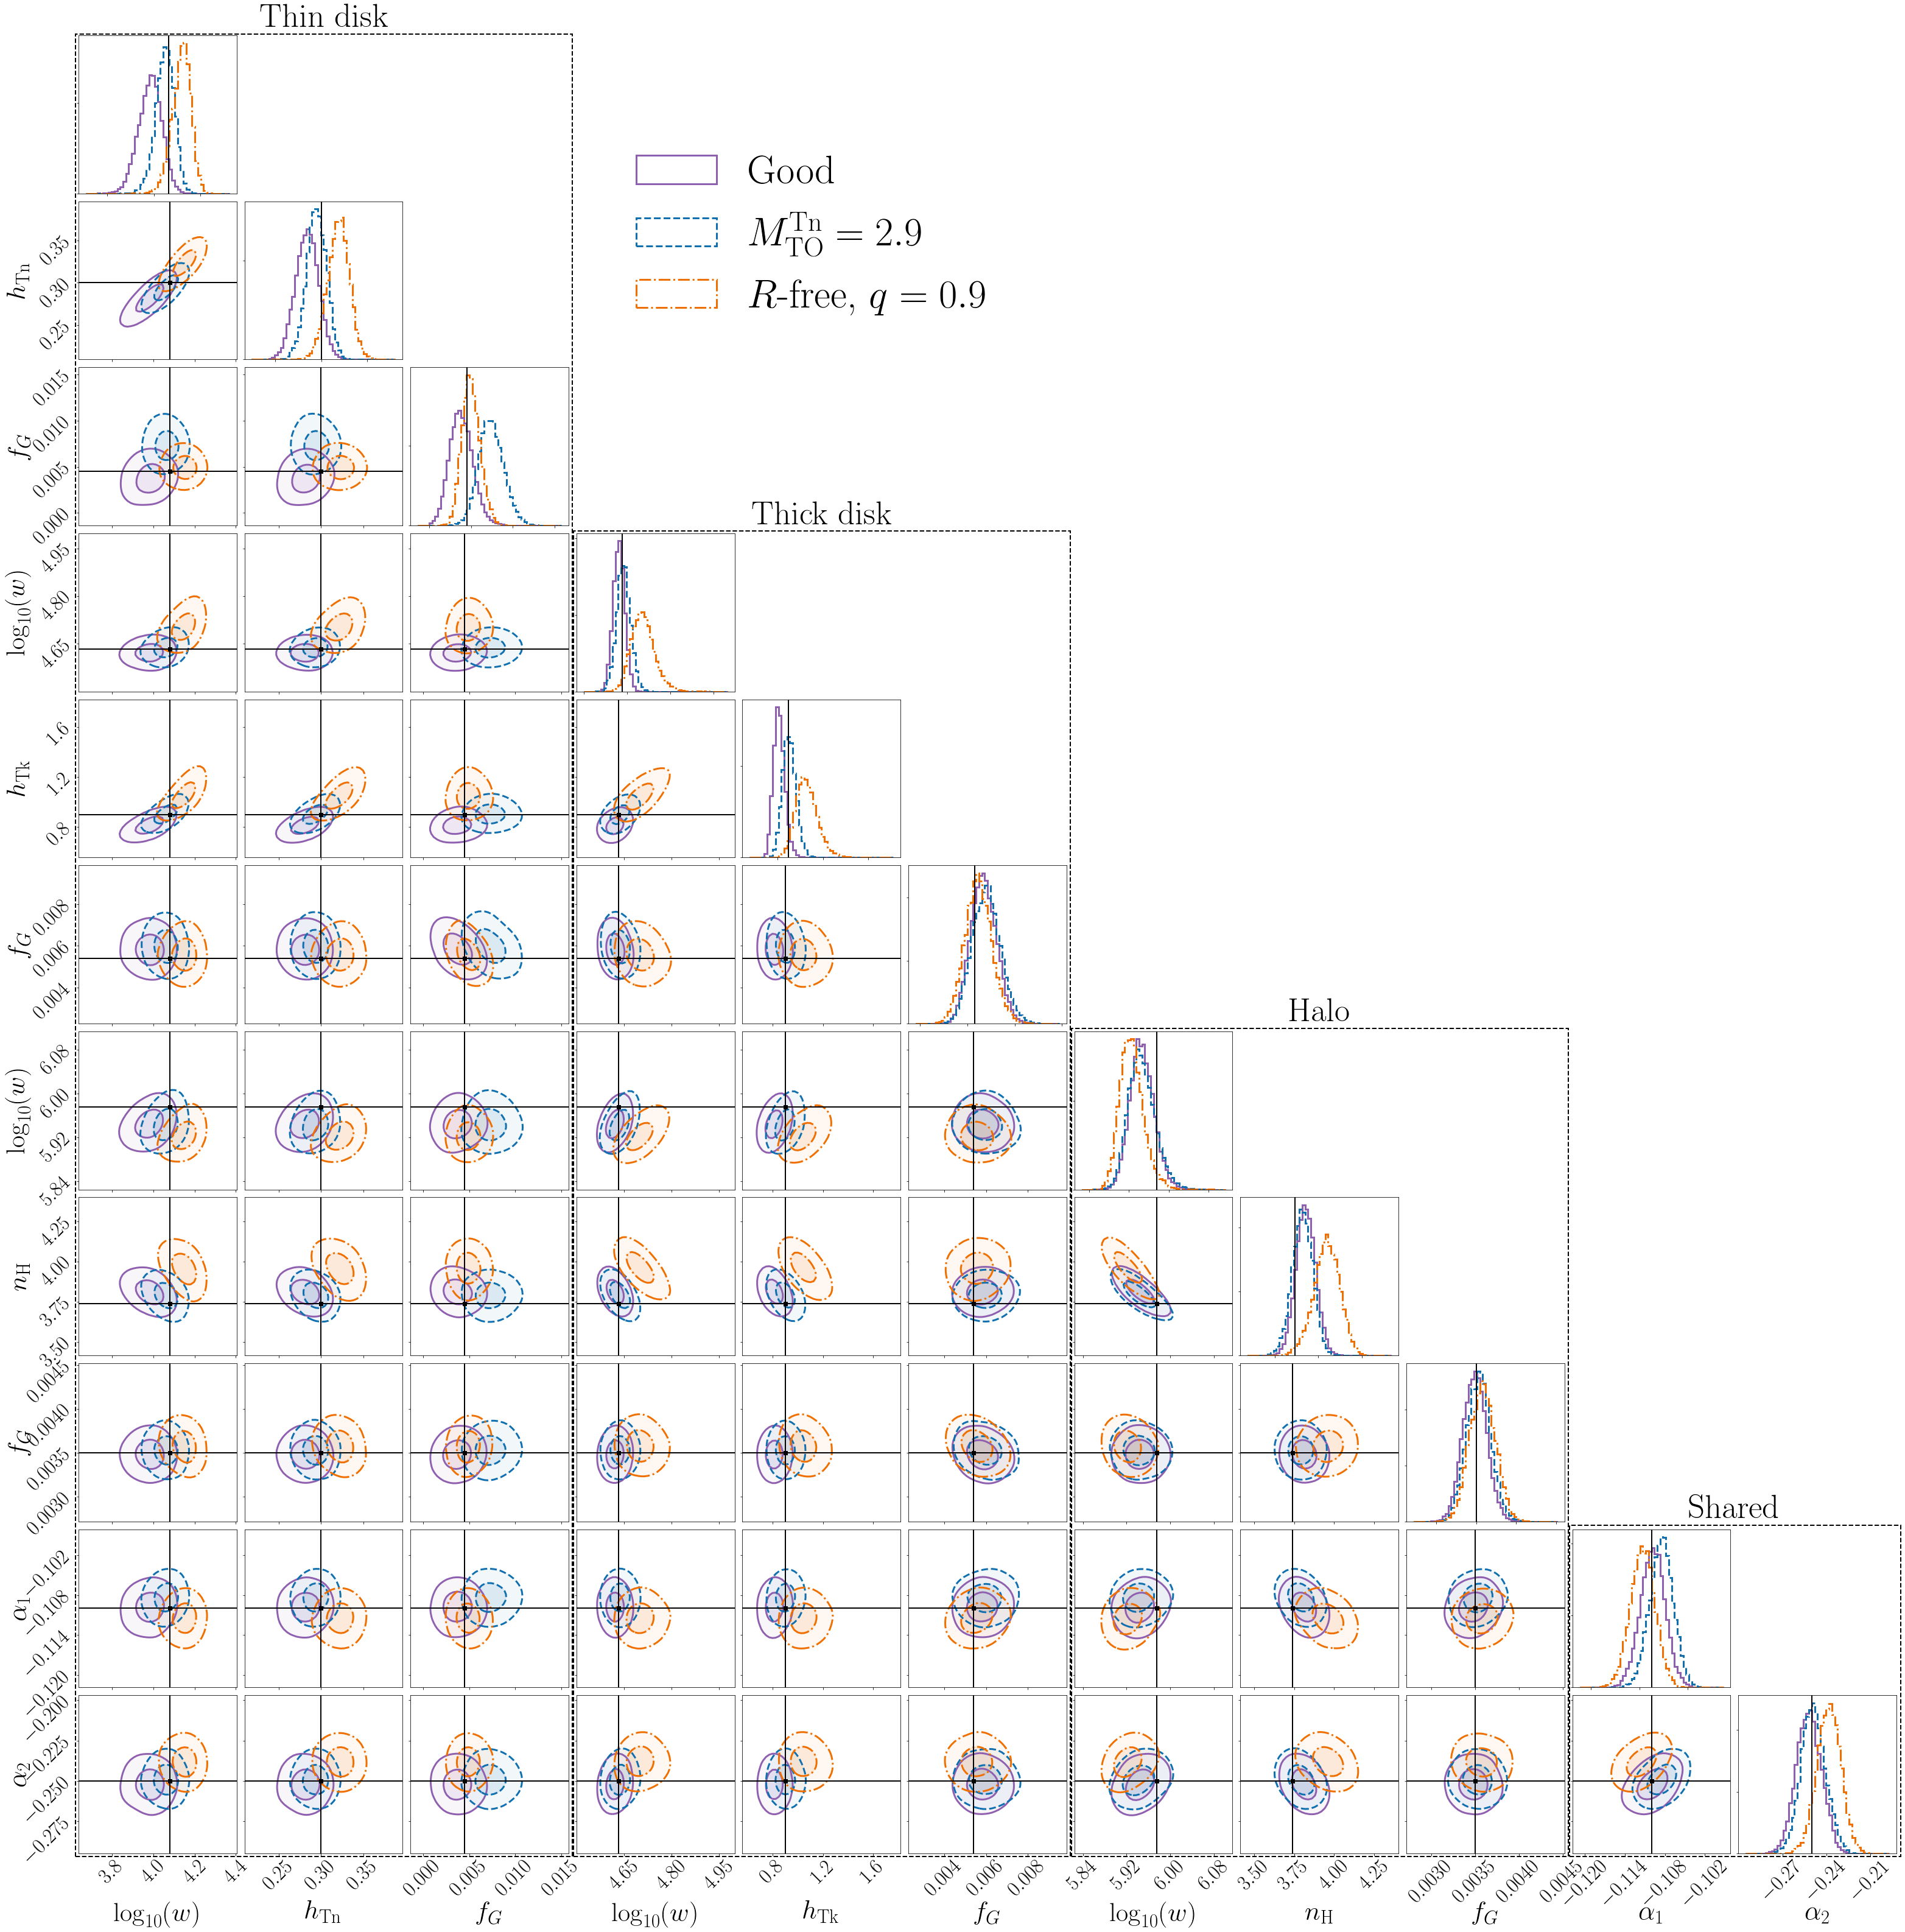

In [28]:
ndim=np.sum([len(model_good.free_pars[i]) for i in model_good.free_pars]); 
fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*4,ndim*4))

def_colours = [tuple(int(col[i:i+2][1:], 16)/16 for i in (0, 2, 4))+(1,) for col in plt.rcParams['axes.prop_cycle'].by_key()['color']]
plotting.layered_corners(chains, labels=labels, functions=functions,
                         index=index, truths=true_params_f, truth_color='k',
                         hist_kwargs={'linewidth':3}, 
                         contour_kwargs={'linewidths':3},
                         colors=[def_colours[i] for i in [4,0,1,3,9]],#[cm.gist_rainbow(0.99), cm.Blues(0.8), cm.Greens(0.8), cm.Reds(0.8)], 
                         alphas=[0.3]*len(index), linestyles=['-','--','-.','-.',':'],
                         fig=fig, ax=axes,
                         label_kwargs={'fontsize':ndim*4}, 
                         legend_kwargs={'fontsize':ndim*6, 'bbox_to_anchor':(3.3,-1.), 'loc':'lower left'})


npar = [len(model_good.free_pars[i]) for i in range(3)]+[len(model_good.free_pars['shd'])]
for jj, cmpt_label in enumerate(['Thin disk', 'Thick disk', 'Halo', 'Shared']):
    ## Boxed regions
    col = np.sum([0,]+npar[:jj])
    axrng = axes[ndim-1,col].axis()
    axdiff = (axrng[1]-axrng[0],axrng[3]-axrng[2])
    pad = 0.02
    rect = Rectangle((axrng[0]-pad*axdiff[0],axrng[2]-pad*axdiff[1]),
                    (1 + 2.4*pad)*npar[jj]*axdiff[0],
                    (1 + 2.4*pad)*(ndim-col)*axdiff[1], fill=False, edgecolor='k', alpha=1,lw=2,ls='--')
    rec = axes[ndim-1,col].add_patch(rect); rec.set_clip_on(False)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()
    plt.sca(axes[ndim-1,col])
    plt.text(cx, cy, cmpt_label, ha='center', va='bottom', fontsize=5*ndim)
    #plt.text()
    
# plt.savefig(f'figs/mock_sys_{file}_{size}_{run_id:03d}_corner.png', bbox_inches='tight', dpi=200)
# plt.savefig(f'figs/mock_sys_{file}_{size}_{run_id:03d}_corner.pdf', bbox_inches='tight', dpi=200)
save_figs(f'figs/mock_sys2_{file}_{size}_{run_id:03d}_corner')

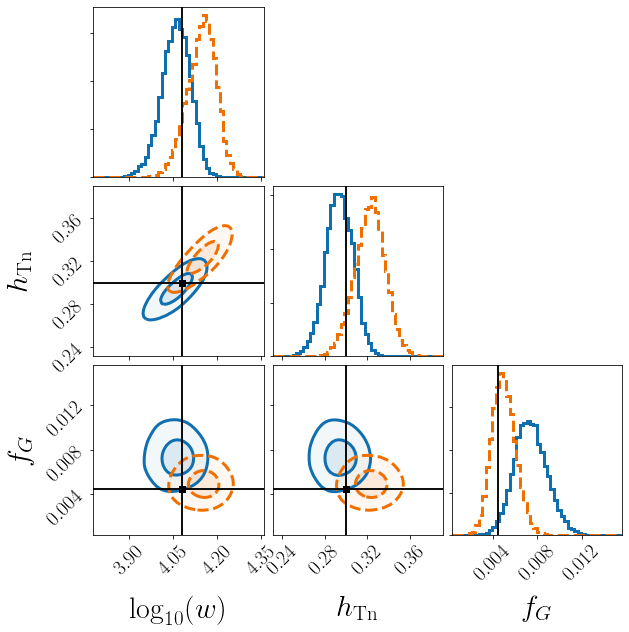

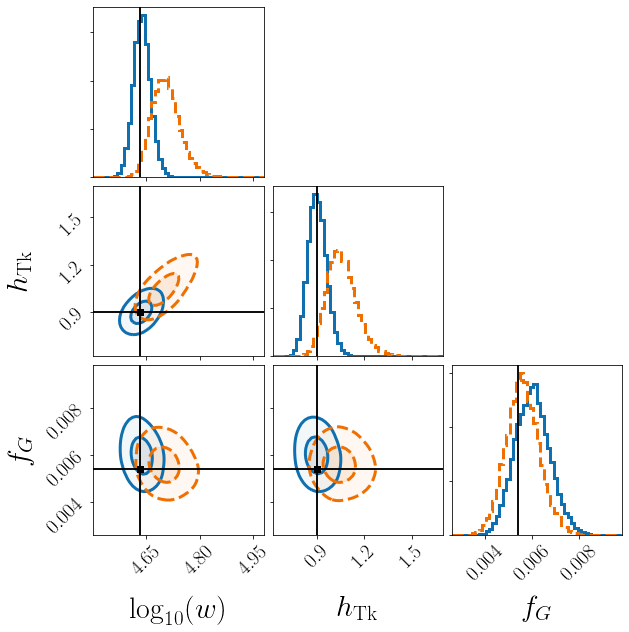

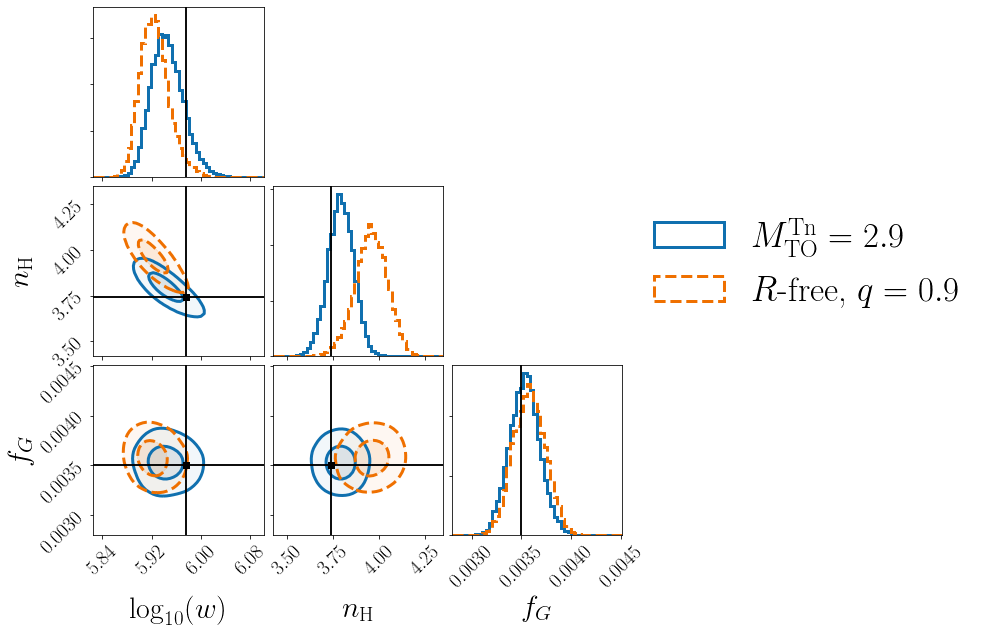

In [16]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

ndims = [len(model_good.free_pars[i]) for i in range(3)]+[len(model_good.free_pars['shd'])]
def_colours = [tuple(int(col[i:i+2][1:], 16)/16 for i in (0, 2, 4))+(1,) for col in plt.rcParams['axes.prop_cycle'].by_key()['color']]
cmpts = ['thin', 'thick', 'halo']

for icmpt in range(len(ndims)-1):
    ndim = ndims[icmpt]
    ipar = int( np.sum(ndims[:icmpt]) )
    
    fig, axes = plt.subplots(ndim,ndim, figsize=(ndim*3,ndim*3))

    plotting.layered_corners([chain[:,:,ipar:ipar+ndim] for chain in chains[1:]], 
                             labels=labels[ipar:ipar+ndim], 
                             functions=functions[ipar:ipar+ndim],
                             index=index[1:], truths=true_params_f[ipar:ipar+ndim], truth_color='k',
                             hist_kwargs={'linewidth':3}, 
                             contour_kwargs={'linewidths':3},
                             colors=[def_colours[i] for i in [4,0,1,3,9]][1:],#[cm.gist_rainbow(0.99), cm.Blues(0.8), cm.Greens(0.8), cm.Reds(0.8)], 
                             alphas=[0.3]*len(index), linestyles=['-','--','-.','-.',':'],
                             fig=fig, ax=axes,
                             label_kwargs={'fontsize':30}, 
                             label_coords={'x':(0.5,-0.35), 'y':(-0.35,0.5)},
                             legend_on=icmpt==2,
                             legend_kwargs={'fontsize':35, 'bbox_to_anchor':(3.1,-.5), 'loc':'center left'})
    
    save_figs(f'figs/mock_sys2_{file}_{size}_{run_id_mock:03d}_{cmpts[icmpt]}_corner')

## Generate Table

In [14]:
import math

In [15]:
functions = [model_good.fid_pars['functions'][j][par] for j in [0,1,2,'shd'] for par in model_good.free_pars[j]]

In [39]:
plabels=[];
for cmpt in np.arange(len(model_good.components)).tolist()+['shd',]:
    for par in model_good.free_pars[cmpt]:
        plabels+=[label_dict[par],]
rows = ["w", "h_\\mathrm{Tn}", "f_G",
        "w", "h_\\mathrm{Tk}", "f_G",
        "w", "n_\\mathrm{H}", "f_G", "\\alpha_1", "\\alpha_2"]
ndim=len(rows)    
    
percentiles = np.zeros((3,ndim,3))
for jj, model in enumerate([model_good, model_mt0, model_R]):

    nwalker, nstep, ndim = model.mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model.mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2)::3].reshape(-1,ndim)
    flat_chain[:,[2,5,8]] *= -1
    percentiles[jj] = np.percentile(flat_chain, (16,50,84), axis=0).T
    
    idw = [0,3,6]
#     percentiles[jj,idw] = np.percentile(flat_chain[:,idw] - scipy.special.logsumexp(flat_chain[:,idw], axis=1)[:,None], 
#                                         (0.16,0.5,0.84), axis=0).T
    
    
# output = "\hline\hline "
# cmpt_labels = ['Thin disk', 'Thick disk', 'Halo', 'Shared']
# fp_prec = [2,3,4,2,3,4,2,3,4,3,3]
# ic = 0; output += f"\n {cmpt_labels[ic]}"
# for ii in range(ndim):
#     output += f"""\n & ${rows[ii]}$"""
#     for jj, cardinal in enumerate(['north', 'south', 'north_Mto', 'south_Mto']):
#         perc_f = functions[ii](percentiles[jj,ii])
#         p10 = math.floor(np.log10(np.abs(perc_f[1])))
#         if p10 in [-1,1]: p10=0
#         output += f""" \n & ${{{format(round(perc_f[1]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}\
# _{{{format(round(min(perc_f[0],perc_f[2])/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}\
# ^{{{format(round(max(perc_f[0],perc_f[2])/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
#         if p10 == 0: output +=  "$"
#         else: output +=  f"\\times 10^{{{p10}}}$"
#     output += "\\\\"
#     if ii in [2,5,8]:
#         output += f"\n & $M_\\mathrm{{TO}}$ & {model.fixed_pars[ic]['Mto']} & & & \\\\"
#         output += f"\n & $\\alpha_3$ & {model[cardinal].fixed_pars[ic]['alpha3']} & & & \\\\"
#         output += f"\n \hline\hline"
#         ic += 1; output += f"\n {cmpt_labels[ic]}"
# output += "\hline\hline \n"

output = ""
cmpt_labels = ['Thin disk', 'Thick disk', 'Halo', 'Shared']
fp_prec = [2,3,2,2,3,2,2,3,2,3,3]
ic = 0; output += cmpt_labels[ic]
for ii in range(ndim):
    true_val = functions[ii](true_params_f[ii])
    p10 = math.floor(np.log10(np.abs(true_val)))
    if p10 in [-1,1]: p10=0
    output += f"""\n & ${rows[ii]}$ """
    #if p10 == 0: output +=  "$"
    #else: output +=  f"\\times 10^{{{p10}}}$"  
    for jj in range(percentiles.shape[0]):
        perc_f = functions[ii](percentiles[jj,ii])
        p10 = math.floor(np.log10(np.abs(perc_f[1])))
        if p10 in [-1,1]: p10=0
        output += f"""\n & ${{{format(round(perc_f[1]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}\
_{{{format(round((min(perc_f[0],perc_f[2])-perc_f[1])/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}\
^{{+{format(round((max(perc_f[0],perc_f[2])-perc_f[1])/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
        if p10 == 0: output +=  "$"
        else: output +=  f"\\times 10^{{{p10}}}$"
    output += "\\\\"
    if ii in [2,5,8]:
        output += f"\n & $M_\\mathrm{{TO}}$ & {model.fixed_pars[ic]['Mto']} & {model.fixed_pars[ic]['Mto']} & {model.fixed_pars[ic]['Mto']} \\\\"
        output += f"\n & $\\alpha_3$ & {model.fixed_pars[ic]['alpha3']} & {model.fixed_pars[ic]['alpha3']} & {model.fixed_pars[ic]['alpha3']} \\\\"
        output += f"\n \hline\hline"
        ic += 1; output += "\n"+cmpt_labels[ic]
output += "\hline\hline \n"

In [40]:
print(output)

Thin disk
 & $w$ 
 & ${9.59}_{-1.35}^{+1.38}\times 10^{3}$
 & ${1.15}_{-0.13}^{+0.13}\times 10^{4}$
 & ${1.41}_{-0.17}^{+0.15}\times 10^{4}$\\
 & $h_\mathrm{Tn}$ 
 & ${0.281}_{-0.015}^{+0.015}$
 & ${0.294}_{-0.013}^{+0.013}$
 & ${0.323}_{-0.015}^{+0.014}$\\
 & $f_G$ 
 & ${3.76}_{-1.30}^{+1.43}\times 10^{-3}$
 & ${7.34}_{-1.39}^{+1.56}\times 10^{-3}$
 & ${4.93}_{-1.01}^{+1.12}\times 10^{-3}$\\
 & $M_\mathrm{TO}$ & 3.1 & 3.1 & 3.1 \\
 & $\alpha_3$ & -0.6 & -0.6 & -0.6 \\
 \hline\hline
Thick disk
 & $w$ 
 & ${4.19}_{-0.19}^{+0.20}\times 10^{4}$
 & ${4.34}_{-0.23}^{+0.25}\times 10^{4}$
 & ${5.05}_{-0.41}^{+0.49}\times 10^{4}$\\
 & $h_\mathrm{Tk}$ 
 & ${0.812}_{-0.045}^{+0.052}$
 & ${0.901}_{-0.055}^{+0.061}$
 & ${1.049}_{-0.085}^{+0.099}$\\
 & $f_G$ 
 & ${5.83}_{-0.66}^{+0.69}\times 10^{-3}$
 & ${5.99}_{-0.73}^{+0.75}\times 10^{-3}$
 & ${5.58}_{-0.69}^{+0.71}\times 10^{-3}$\\
 & $M_\mathrm{TO}$ & 3.1 & 3.1 & 3.1 \\
 & $\alpha_3$ & -0.77 & -0.77 & -0.77 \\
 \hline\hline
Halo
 & $w$ 
 & ${8.

In [24]:
plabels=[];
for cmpt in np.arange(len(model_good.components)).tolist()+['shd',]:
    for par in model_good.free_pars[cmpt]:
        plabels+=[label_dict[par],]
rows = ["w", "h_\\mathrm{Tn}", "f_G",
        "w", "h_\\mathrm{Tk}", "f_G",
        "w", "n_\\mathrm{H}", "f_G", "\\alpha_1", "\\alpha_2"]
ndim=len(rows)    
    
percentiles = np.zeros((2,ndim,3))
for jj, model in enumerate([model_mt0, model_R]):

    nwalker, nstep, ndim = model.mcmc_results['chain']['sf_perr_mcmc'].shape
    flat_chain = model.mcmc_results['chain']['sf_perr_mcmc'][:,int(nstep/2)::3].reshape(-1,ndim)
    flat_chain[:,[2,5,8]] *= -1
    percentiles[jj] = np.percentile(flat_chain, (16,50,84), axis=0).T
    
    idw = [0,3,6]
    

output = ""
cmpt_labels = ['Thin disk', 'Thick disk', 'Halo', 'Shared']
fp_prec = [2,3,2,2,3,2,2,3,2,3,3]
ic = 0; output += cmpt_labels[ic]
for ii in range(ndim):
    true_val = functions[ii](true_params_f[ii])
    p10 = math.floor(np.log10(np.abs(true_val)))
    if p10 in [-1,1]: p10=0
    output += f"""\n & ${rows[ii]}$ & ${{{format(round(true_val/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}$"""
    #if p10 == 0: output +=  "$"
    #else: output +=  f"\\times 10^{{{p10}}}$"  
    for jj in range(percentiles.shape[0]):
        perc_f = functions[ii](percentiles[jj,ii])
        p10 = math.floor(np.log10(np.abs(perc_f[1])))
        if p10 in [-1,1]: p10=0
        output += f"""\n & ${{{format(round(perc_f[1]/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}\
_{{{format(round((min(perc_f[0],perc_f[2])-perc_f[1])/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}\
^{{+{format(round((max(perc_f[0],perc_f[2])-perc_f[1])/10**p10, fp_prec[ii]), f".{fp_prec[ii]:.0f}f")}}}"""
        if p10 == 0: output +=  "$"
        else: output +=  f"\\times 10^{{{p10}}}$"
    output += "\\\\"
    if ii in [2,5,8]:
#         output += f"\n & $M_\\mathrm{{TO}}$ & {model.fixed_pars[ic]['Mto']} & {model.fixed_pars[ic]['Mto']} & {model.fixed_pars[ic]['Mto']} \\\\"
#         output += f"\n & $\\alpha_3$ & {model.fixed_pars[ic]['alpha3']} & {model.fixed_pars[ic]['alpha3']} & {model.fixed_pars[ic]['alpha3']} \\\\"
         output += f"\n \hline\hline"
         ic += 1; output += "\n"+cmpt_labels[ic]
output += "\hline\hline \n"

In [25]:
print(output)

Thin disk
 & $w$ & ${1.20}$
 & ${1.15}_{-0.13}^{+0.13}\times 10^{4}$
 & ${1.41}_{-0.17}^{+0.15}\times 10^{4}$\\
 & $h_\mathrm{Tn}$ & ${0.300}$
 & ${0.294}_{-0.013}^{+0.013}$
 & ${0.323}_{-0.015}^{+0.014}$\\
 & $f_G$ & ${4.50}$
 & ${7.34}_{-1.39}^{+1.56}\times 10^{-3}$
 & ${4.93}_{-1.01}^{+1.12}\times 10^{-3}$\\
 \hline\hline
Thick disk
 & $w$ & ${4.30}$
 & ${4.34}_{-0.23}^{+0.25}\times 10^{4}$
 & ${5.05}_{-0.41}^{+0.49}\times 10^{4}$\\
 & $h_\mathrm{Tk}$ & ${0.900}$
 & ${0.901}_{-0.055}^{+0.061}$
 & ${1.049}_{-0.085}^{+0.099}$\\
 & $f_G$ & ${5.40}$
 & ${5.99}_{-0.73}^{+0.75}\times 10^{-3}$
 & ${5.58}_{-0.69}^{+0.71}\times 10^{-3}$\\
 \hline\hline
Halo
 & $w$ & ${9.45}$
 & ${8.78}_{-0.48}^{+0.59}\times 10^{5}$
 & ${8.39}_{-0.40}^{+0.48}\times 10^{5}$\\
 & $n_\mathrm{H}$ & ${3.740}$
 & ${3.791}_{-0.070}^{+0.070}$
 & ${3.957}_{-0.089}^{+0.086}$\\
 & $f_G$ & ${3.50}$
 & ${3.53}_{-0.15}^{+0.15}\times 10^{-3}$
 & ${3.58}_{-0.16}^{+0.16}\times 10^{-3}$\\
 \hline\hline
Shared
 & $\alpha_1$ & $